# Project Deep Leaning II 
Dumont Axel

In [136]:
import numpy as np 
from numpy.random import rand, shuffle
import matplotlib.pyplot as plt

In [137]:
def cross_entropy(true_labels, predicted_labels):
    return -np.sum(true_labels * np.log(predicted_labels))

In [138]:
def display_binary_vectors(binary_vectors, rows = 5, cols = 5, shape = (20, 16)):
    """
    Display a grid of binary vectors as images.

    Parameters:
    - binary_vectors: List of binary vectors (each vector is of length 320).
    - rows: Number of rows in the grid.
    - cols: Number of columns in the grid.
    """
    # Create a subplot grid with specified rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

    for i in range(rows):
        for j in range(cols):
            # Get the binary vector corresponding to the current position
            index = i * cols + j
            if index < len(binary_vectors):
                binary_vector = binary_vectors[index]
                # Reshape the binary vector to a 20x16 matrix
                image_matrix = np.reshape(binary_vector, shape)
                # Display the image in the current subplot
                axes[i, j].imshow(image_matrix, cmap='gray', interpolation='nearest')
                axes[i, j].axis('off')  # Turn off axis labels for cleaner display
            else:
                # If there are fewer binary vectors than expected, leave the subplot empty
                axes[i, j].axis('off')

    plt.show()

# Data
Les données BinaryAlphaDigits sont disponible ici: https://cs.nyu.edu/~roweis/data.html 

In [139]:
from scipy.io import loadmat
mat = loadmat('binaryalphadigs.mat')

labels = mat["classlabels"][0]
data = mat["dat"]

n_chars,  n_examples = data.shape

def lire_alpha_digit(char_inds, data):
    """Extrait de datales images des caractères dont les index sont dans char_inds

    Args:
        index_char (iterable): les index des caractères à extraire
        data (np.array): dataset brut 

    Returns:
        np.array: 
    """
    li_data = []
    for index in char_inds:
        li_char = []
        for i in range(n_examples):
            li_char.append(data[index,i].flatten())
        li_data.append(np.stack(li_char, axis=0))
    return np.concatenate(li_data,axis =0)

In [140]:
from mnist import MNIST

def lire_MNIST(shuffle= True, data_size=60000):
    
    mndata = MNIST('./data/MNIST/raw')
    images_train, labels_train = mndata.load_training()
    images_train = np.array(images_train)
    labels_train = np.array(labels_train)
    images_test, labels_test = mndata.load_testing()
    images_test = np.array(images_test)
    labels_test = np.array(labels_test)
    if shuffle:
        seed = np.random.randint(0, 10000)
        for imgs, lbls in [(images_train, labels_train), (images_test, labels_test)]:
            np.random.seed(seed)
            np.random.shuffle(imgs)
            np.random.seed(seed)
            np.random.shuffle(lbls)
    if data_size is not None:
        images_train = images_train[:data_size]
        labels_train = labels_train[:data_size]
        images_test = images_test[:data_size]
        labels_test = labels_test[:data_size]
    return images_train, labels_train, images_test, labels_test

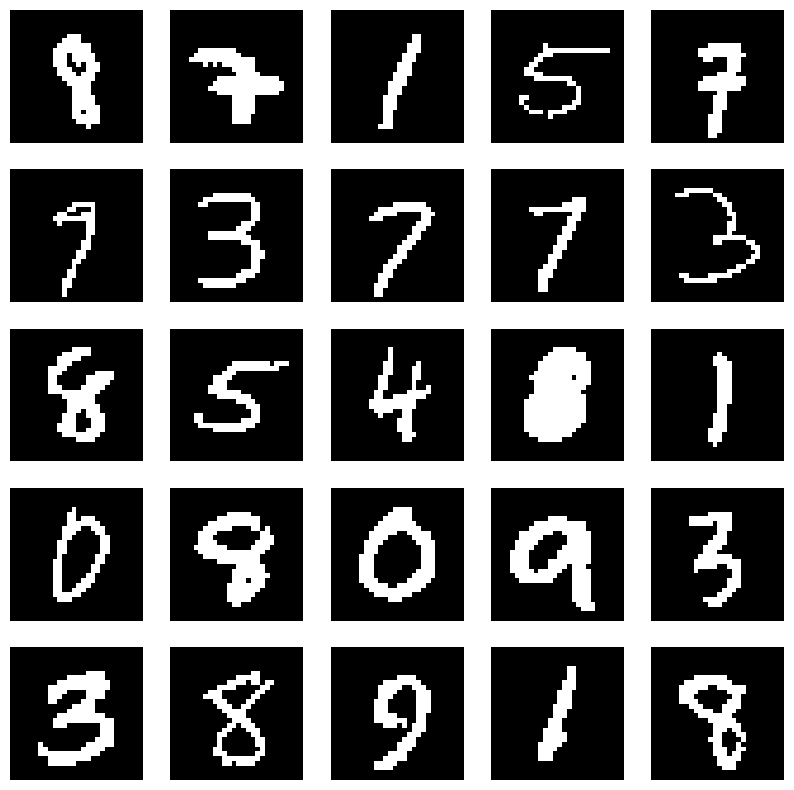

In [141]:
data_size = 2000
images_train, labels_train, images_test, labels_test = lire_MNIST(shuffle=True, data_size=data_size)

# Binarize data
images_train = (images_train > 127) * 1
images_test = (images_test > 127) * 1

# Vectorize labels
labels_train = np.eye(10)[labels_train]

display_binary_vectors(images_train, cols=5, rows=5, shape=(28,28))

# RBM Model definition

In [179]:
class RBM():
    def __init__(self,p,q):
        """builds a RBM from the given parameters.
        Args:
            p (int) : input dimension 
            q (int) : Hidden Dimension
            """
        variance = 0.01
        self.p = p
        self.q = q
        self.a = np.zeros((1,p))
        self.b = np.zeros((1,q))
        self.W = np.random.normal(0, np.sqrt(variance), size=(p,q))

    def entree_sortie_RBM(self, V):
        """Calcule la distribution de la variable latente à partir d'une entree"""
        return 1 / (1 + np.exp(-( V @ self.W + self.b) ))
    
    def sortie_entree_RBM(self, H):
        """Calcule la distribution d'input à partir d'une variable latente"""
        return 1 / (1 + np.exp(-( H @ self.W.T + self.a) ))

    def train(self, X, epochs=100, lr=0.01, batchsize=32, verbose=100, plot = True):
        """ Trains the RBM 
        Args:
            X array(N,p) : dataset
        
        """
        N , p = X.shape
        q = self.b.shape[1]
        hist = []
        for epoch in range(1, epochs+1):
            shuffle(X)
            e_loss = []

            for j in range(N//batchsize): #impement last batch 

                V_0 = X[j*batchsize: (j+1)*batchsize]
                # print(V_0.shape)
                
                Ph_0 = self.entree_sortie_RBM(V_0)
                # tirage de la variable latente
                h_0 = ( rand(q) < Ph_0 )* 1.0
                
                Pv_1 = self.sortie_entree_RBM(h_0)
                #tirage donnée reconstruite
                V_1 = ( rand(p) < Pv_1 )* 1.0

                Ph_1 = self.entree_sortie_RBM(V_1)
                # tirage de la variable latente
                h_1 = ( rand(q) < Ph_1 )* 1.0

                # gradients
                grad_W = (V_0.T @ Ph_0 - V_1.T @ Ph_1)
                grad_A = np.sum(V_0 - V_1,axis=0)
                grad_B = np.sum(h_0 - h_1,axis=0)
                
                # gradient step
                self.W += lr * grad_W / batchsize
                self.a += lr * grad_A / batchsize
                self.b += lr * grad_B / batchsize
                e_loss.append(np.mean((V_1-V_0)**2))

            #compute mean loss over all training set
            loss = np.mean(e_loss)
            hist.append(loss)
            if epoch%verbose == 0 : 
                print(f"epoch {epoch}, rec loss: {loss}")
        
        if plot: plt.plot(hist)
        return hist

        
    def generer_image_RBM(self, num_samples, num_iter):
        """
        Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
        (where each step consists of updating all the hidden units, and then updating all of the visible units),
        taking a sample of the visible units at each step.
        Note that we only initialize the network *once*, so these samples are correlated.

        Returns
        -------
        samples: A matrix, where each row is a sample of the visible units produced while the network was
        daydreaming.
        """
        p = self.a.shape[1]
        q = self.b.shape[1]
        variance = 0.01

        samples = np.random.normal(0, np.sqrt(variance), size=(num_samples, p))

        for i in range(num_samples):

            V_0 = samples[i,:]
            for iter in range(num_iter):
                Ph_0 = self.entree_sortie_RBM(V_0)
                # tirage de la variable latente
                h_0 = ( rand(q) < Ph_0 )* 1.0
                
                Pv_1 = self.sortie_entree_RBM(h_0)
                #tirage donnée reconstruite
                V_0 = ( rand(p) < Pv_1 )* 1.0

            
            samples[i,:] = V_0

        return samples
        
    def _logistic(self, x):
        return 1.0 / (1 + np.exp(-x))

# DBN Model Definition

In [210]:
class DBN():
    def __init__(self, network_shape):
        self.rbm_pile = []
        for i in range(len(network_shape) -1):
            self.rbm_pile.append(RBM(network_shape[i], network_shape[i+1]))
    
    def train_dbn(self, X, epochs=100, lr=0.01, batchsize=32, verbose=100, plot = True):
        """ Trains the DBN 
        Args:
            X array(N,p) : dataset
        
        """
        X_copy = X.copy()
        hist = []
        for i, rbm in enumerate(self.rbm_pile):
            print(f"Training RBM {i+1}")
            hist.append(rbm.train(X_copy, epochs=epochs, lr=lr, batchsize=batchsize, verbose=verbose, plot = False))
            X_copy = rbm.entree_sortie_RBM(X_copy)
        return hist
    
    def generer_image_DBN(self, num_samples, num_iter):
        """
        Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
        (where each step consists of updating all the hidden units, and then updating all of the visible units),
        taking a sample of the visible units at each step.
        Note that we only initialize the network *once*, so these samples are correlated.

        Returns
        -------
        samples: A matrix, where each row is a sample of the visible units produced while the network was
        daydreaming.
        """
        samples = 0.5
        for rbm in self.rbm_pile[::-1]:
            V_0 = (np.random.rand(num_samples, rbm.q) < samples) * 1
            for j in range(num_iter):
                samples = (np.random.rand(num_samples, rbm.p) < rbm.sortie_entree_RBM(V_0)) * 1
                V_0 = (np.random.rand(num_samples, rbm.q) < rbm.entree_sortie_RBM(samples)) * 1

        return samples
    

# DNN Model Definition

In [161]:
class DNN():
    def __init__(self, network_shape):
        """
        Builds a Deep Neural Network from the given parameters.
        
        Args:
            network_shape ((n_layer,) array): Shape of the network.
        """
        self.dnn = []
        self.net = network_shape[-2]
        for i in range(len(network_shape) - 2):
            self.dnn.append(RBM(network_shape[i], network_shape[i + 1]))

    def pretrain(self, X, epochs=100, lr=0.01, batchsize=32, verbose=100):
        """
        Pretrain the DNN.

        Args:
            X ((N,p) array): Dataset.
            epochs (int): Number of iterations of gradient descent.
            lr (float): Learning rate of the gradient descent.
            batchsize (int): Size of the batch.
        """

        x = X.copy()
        for i, rbm in enumerate(self.dnn):
            if verbose:
                print(f"Pretraining layer {i}")
            rbm.train(x, epochs, lr, batchsize, verbose=verbose, plot=False)
            x = rbm.entree_sortie_RBM(x)
    
    def calcul_softmax(self, RBM, X):
        """
        Compute the softmax of the output layer.
        """
        return np.exp(X @ RBM.W + RBM.b) / np.sum(np.exp(X @ RBM.W + RBM.b), axis=1, keepdims=True)

    def entree_sortie_reseau(self, X):
        """
        Compute the output for each layer of the network and the probabilities of the output layer.
        """
        sorties = [X]
        h = X
        for rbm in self.dnn[:-1]:
            h = rbm.entree_sortie_RBM(h)
            sorties.append(h)
        probs = self.calcul_softmax(self.dnn[-1], h)
        sorties.append(probs)
        return sorties, probs

    def retropropagation(self, X, labels, epochs=100, lr=0.01, batchsize=32, verbose=100, plot=False):
        """
        Backpropagation of the DNN.

        Args:
            X ((N,p) array): Dataset.
            labels ((N,q) array): Labels.
            epochs (int): Number of iterations of gradient descent.
            lr (float): Learning rate of the gradient descent.
            batchsize (int): Size of the batch.
        """

        self.dnn.append(RBM(self.net, labels.shape[1]))
        n_layers = len(self.dnn)
        N = X.shape[0]

        plot_loss = []
        plot_accuracy = []
        for epoch in range(epochs):
            seed = np.random.randint(0, 10000)
            X_copy = X.copy()
            labels_copy = labels.copy()
            np.random.seed(seed)
            np.random.shuffle(X_copy)
            np.random.seed(seed)
            np.random.shuffle(labels_copy)

            total_loss = 0
            total_accuracy = 0

            for j in range(0, N, batchsize):

                X_batch = X_copy[j: min(j + batchsize, N)]
                labels_batch = labels_copy[j: min(j + batchsize, N)]

                batch_size = X_batch.shape[0] # size of the batch (may be less than batchsize for the last batch)

                # Forward
                pred, probs = self.entree_sortie_reseau(X_batch)
                total_loss += cross_entropy(labels_batch, probs)
                total_accuracy += np.sum(np.argmax(probs, axis=1) == np.argmax(labels_batch, axis=1))

                for l in range(n_layers):
                    # Backward
                    if l == 0:
                        delta = pred[n_layers] - labels_batch
                    else:
                        delta = dA * (pred[n_layers-l] * (1 - pred[n_layers-l]))
                    dW = pred[n_layers-l-1].T.dot(delta) / batch_size
                    db = np.sum(delta, axis=0) / batch_size
                    dA = delta.dot(self.dnn[n_layers-l-1].W.T)
                    
                    # Update weights
                    self.dnn[n_layers-l-1].W -= lr * dW
                    self.dnn[n_layers-l-1].b -= lr * db

            plot_loss.append(total_loss/N)
            plot_accuracy.append(total_accuracy/N)  

            if epoch%verbose==0 and epoch!=0:
                pred, probs = self.entree_sortie_reseau(X)
                print(f"Epoch {epoch} : loss = {total_loss/N}, accuracy = {total_accuracy / N}")
        
        if plot:
            # Create a figure and a set of subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            fig.suptitle('Loss and Accuracy')

            # Plotting the loss on the first y-axis
            ax1.plot(plot_loss, 'r', label='Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss', color='r')
            ax1.tick_params('y', colors='r')

            # Creating a second y-axis for accuracy
            ax2.plot(plot_accuracy, 'b', label='Accuracy')
            ax2.set_ylabel('Accuracy', color='b')
            ax2.tick_params('y', colors='b')
        
        return plot_loss, plot_accuracy

    def test_DNN(self, X, labels):
        """
        Test the performances of the DNN on the given dataset.
        """
        _, probs = self.entree_sortie_reseau(X)
        estimated_labels = np.argmax(probs, axis=1)
        error_rate = np.sum(estimated_labels != labels) / X.shape[0]
        return error_rate

# Training

## Simple Training on only digits: RBM

epoch 100, rec loss: 0.32859821428571434
epoch 200, rec loss: 0.28791964285714283
epoch 300, rec loss: 0.25823214285714285
epoch 400, rec loss: 0.23791071428571425
epoch 500, rec loss: 0.22471428571428573
epoch 600, rec loss: 0.20975892857142855
epoch 700, rec loss: 0.20641071428571428
epoch 800, rec loss: 0.20282142857142857
epoch 900, rec loss: 0.19325892857142857
epoch 1000, rec loss: 0.18255357142857145


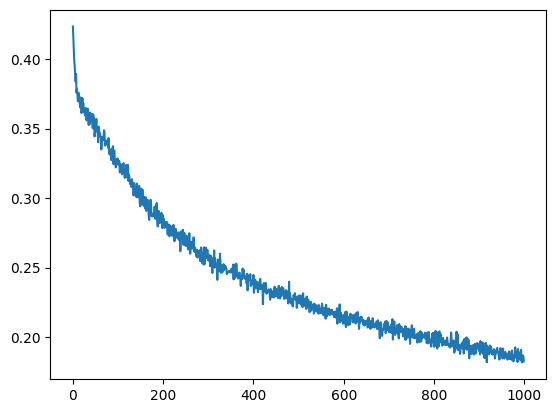

In [145]:
X = lire_alpha_digit(list(range(10)),data)
#print(X.shape)
rbm = RBM(X.shape[1], 500)

hist = rbm.train(X,lr=1e-3,epochs=1000, batchsize=50, verbose=100)


### Plotting generated results

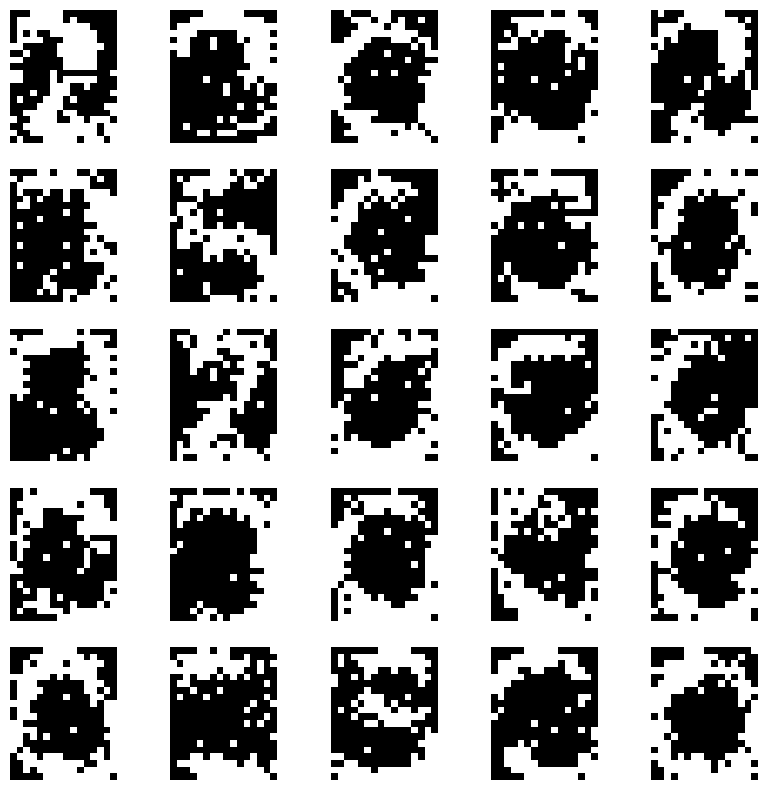

In [146]:
binary_list = rbm.generer_image_RBM(25, 50)

# display_binary_vectors(X[:25])
display_binary_vectors(binary_list)

## Simple Training on only digits: DBN

In [211]:
X = lire_alpha_digit(list(range(10)), data)
dbn = DBN([320, 160, 100, 50, 10])
hist = dbn.train_dbn(X, epochs=1000, lr=0.01, batchsize=32, verbose=999)

Training RBM 1
epoch 999, rec loss: 0.099560546875
Training RBM 2
epoch 999, rec loss: 0.09637044372880103
Training RBM 3
epoch 999, rec loss: 0.12818133415871574
Training RBM 4
epoch 999, rec loss: 0.19757696106063005


### Plotting Results

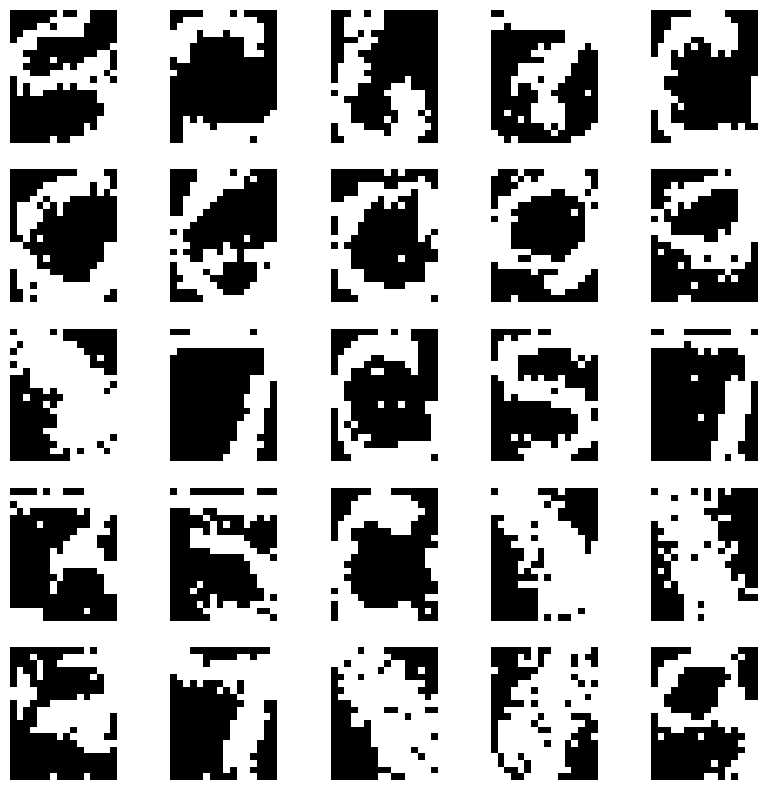

In [212]:
binary_list = dbn.generer_image_DBN(25, 50)

# display_binary_vectors(X[:25])
display_binary_vectors(binary_list)

## Simple Training on MNIST: DNN

Epoch 0 : loss = 2.3135001306025593, accuracy = 0.1085
Error rate for DNN not pretrained: 0.1675
Pretraining layer 0
epoch 99, rec loss: 0.05167474489795918
Pretraining layer 1
epoch 99, rec loss: 0.10978907711048021
Pretraining layer 2
epoch 99, rec loss: 0.11525023246505448
Epoch 0 : loss = 2.0556349188606364, accuracy = 0.3045
Error rate for DNN pretrained: 0.116


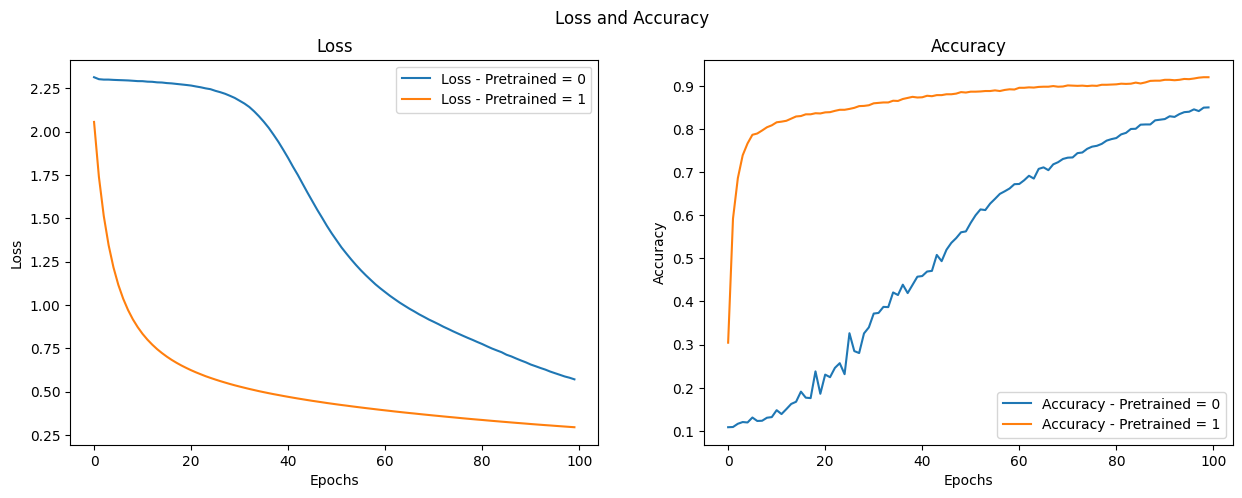

In [162]:
network_size = [784, 200, 200, 30, 10]
epochs = 100
lr = 0.1
batch_size = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Loss and Accuracy')

for i in range(2):
    dnn = DNN(network_size)
    if i==1:
        dnn.pretrain(images_train, epochs, lr, batch_size, 99)
    loss, accuracy = dnn.retropropagation(images_train, labels_train, epochs, lr, batch_size, 100, False)
    error_rate = dnn.test_DNN(images_test, labels_test)
    if i==0:
        print(f"Error rate for DNN not pretrained: {error_rate}")
    else:
        print(f"Error rate for DNN pretrained: {error_rate}")

    ax1.plot(loss, label=f"Loss - Pretrained = {i}")
    ax2.plot(accuracy, label=f"Accuracy - Pretrained = {i}")

    ax1.set_title("Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

plt.show()

# Hyperparamters for RBM / DBN on Binary Alpha Digits

## Effect of the hidden dimension
here we train only on one label, and we study the impact of the hidden layer dimension on the mean reconstruction error 

(39, 320)
epoch 500, rec loss: 0.43466796875
epoch 1000, rec loss: 0.3806640625
epoch 500, rec loss: 0.31201171875
epoch 1000, rec loss: 0.25322265625
epoch 500, rec loss: 0.23427734375
epoch 1000, rec loss: 0.18447265625
epoch 500, rec loss: 0.20048828125
epoch 1000, rec loss: 0.166015625
epoch 500, rec loss: 0.185546875
epoch 1000, rec loss: 0.146484375
epoch 500, rec loss: 0.164453125
epoch 1000, rec loss: 0.1298828125
epoch 500, rec loss: 0.150390625
epoch 1000, rec loss: 0.10869140625
epoch 500, rec loss: 0.11884765625
epoch 1000, rec loss: 0.10341796875


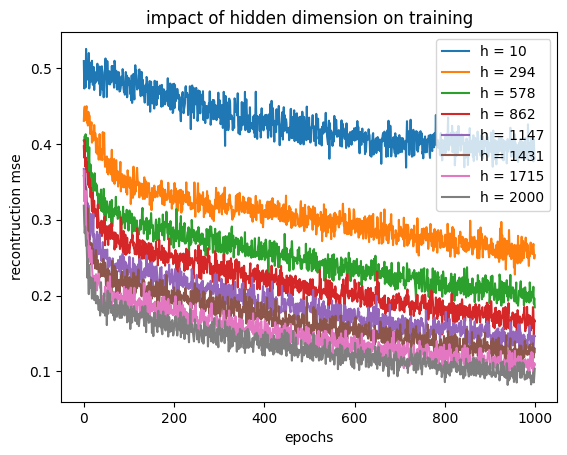

In [164]:
# we train on letter A
X = lire_alpha_digit([10],data)
n_imgs = 5
print(X.shape)
h_dims = list(np.linspace(10,2000,8, dtype=np.int16))
results = np.empty((5,X.shape[1]))

for h in h_dims: 
    rbm = RBM(X.shape[1], h)
    #train 
    hist = rbm.train(X,lr=1e-3,epochs=1000, batchsize=32, verbose=500, plot=False)
    results = np.vstack((results,rbm.generer_image_RBM(5, 100)))
    plt.plot(hist, label=f"h = {h}")
plt.title("impact of hidden dimension on training")
plt.xlabel("epochs")
plt.ylabel("recontruction mse")
plt.legend()


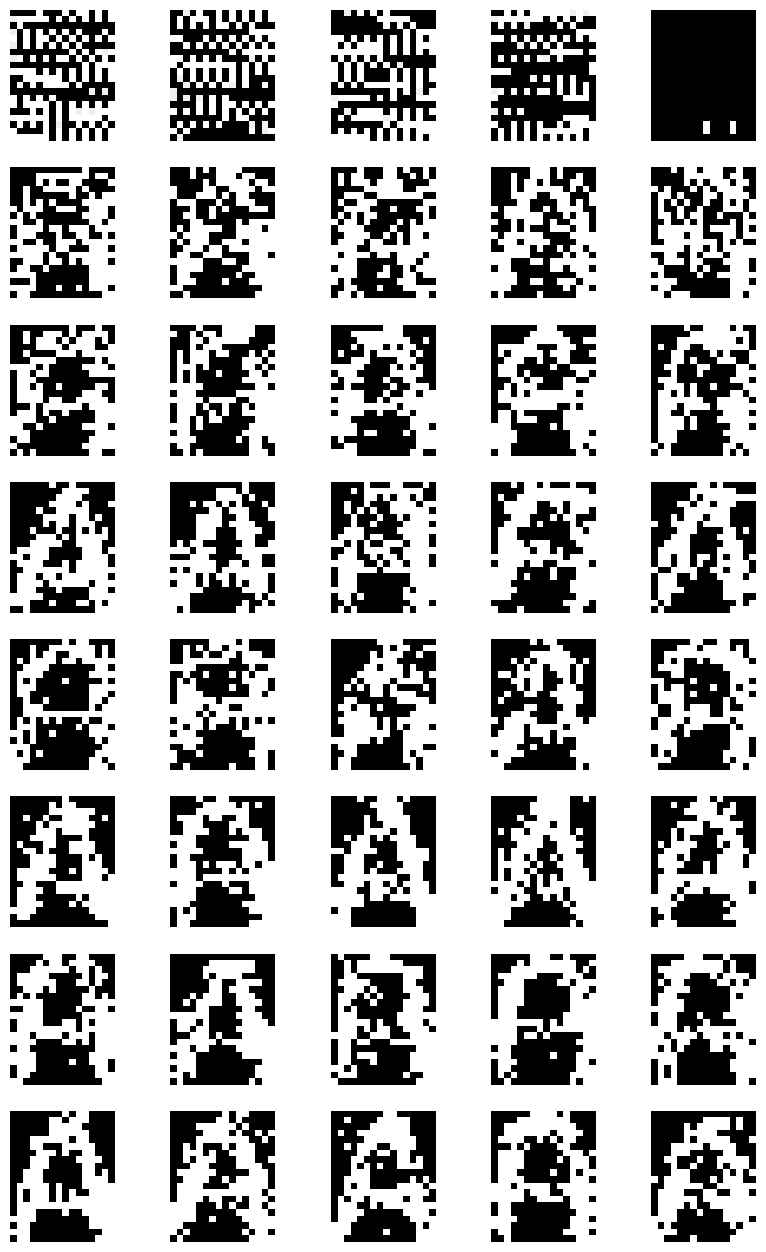

In [165]:
# display_binary_vectors(X[:25])
display_binary_vectors(results,rows=8)

## Training on only one label

epoch 999, rec loss: 0.025390625
epoch 999, rec loss: 0.03671875
epoch 999, rec loss: 0.025
epoch 999, rec loss: 0.03173828125
epoch 999, rec loss: 0.02548828125
epoch 999, rec loss: 0.02646484375
epoch 999, rec loss: 0.023828125
epoch 999, rec loss: 0.0216796875
epoch 999, rec loss: 0.0451171875
epoch 999, rec loss: 0.0408203125


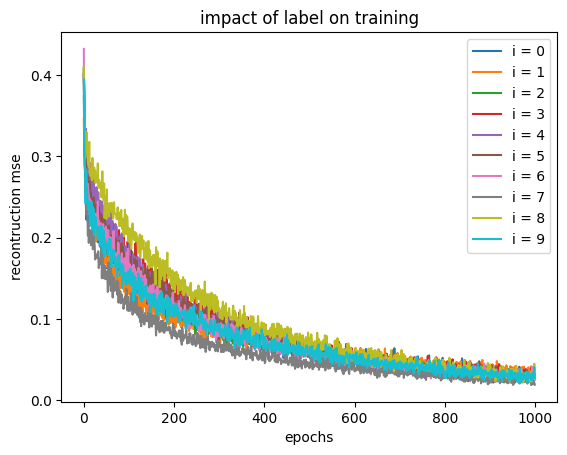

In [166]:
binary_temp = []
for i in range(10):
    X = lire_alpha_digit([i],data)
    rbm = RBM(X.shape[1], 800)
    hist = rbm.train(X,lr=1e-2,epochs=1000, batchsize=32,verbose=999, plot=False)

    plt.plot(hist, label=f"i = {i}")

    for j in range(1,11):
        binary_temp.append(rbm.generer_image_RBM(1, 100 * j))

plt.title("impact of label on training")
plt.xlabel("epochs")
plt.ylabel("recontruction mse")
plt.legend()

binary_list = []
for i in binary_temp:
    for vector in i:
        binary_list.append(vector)


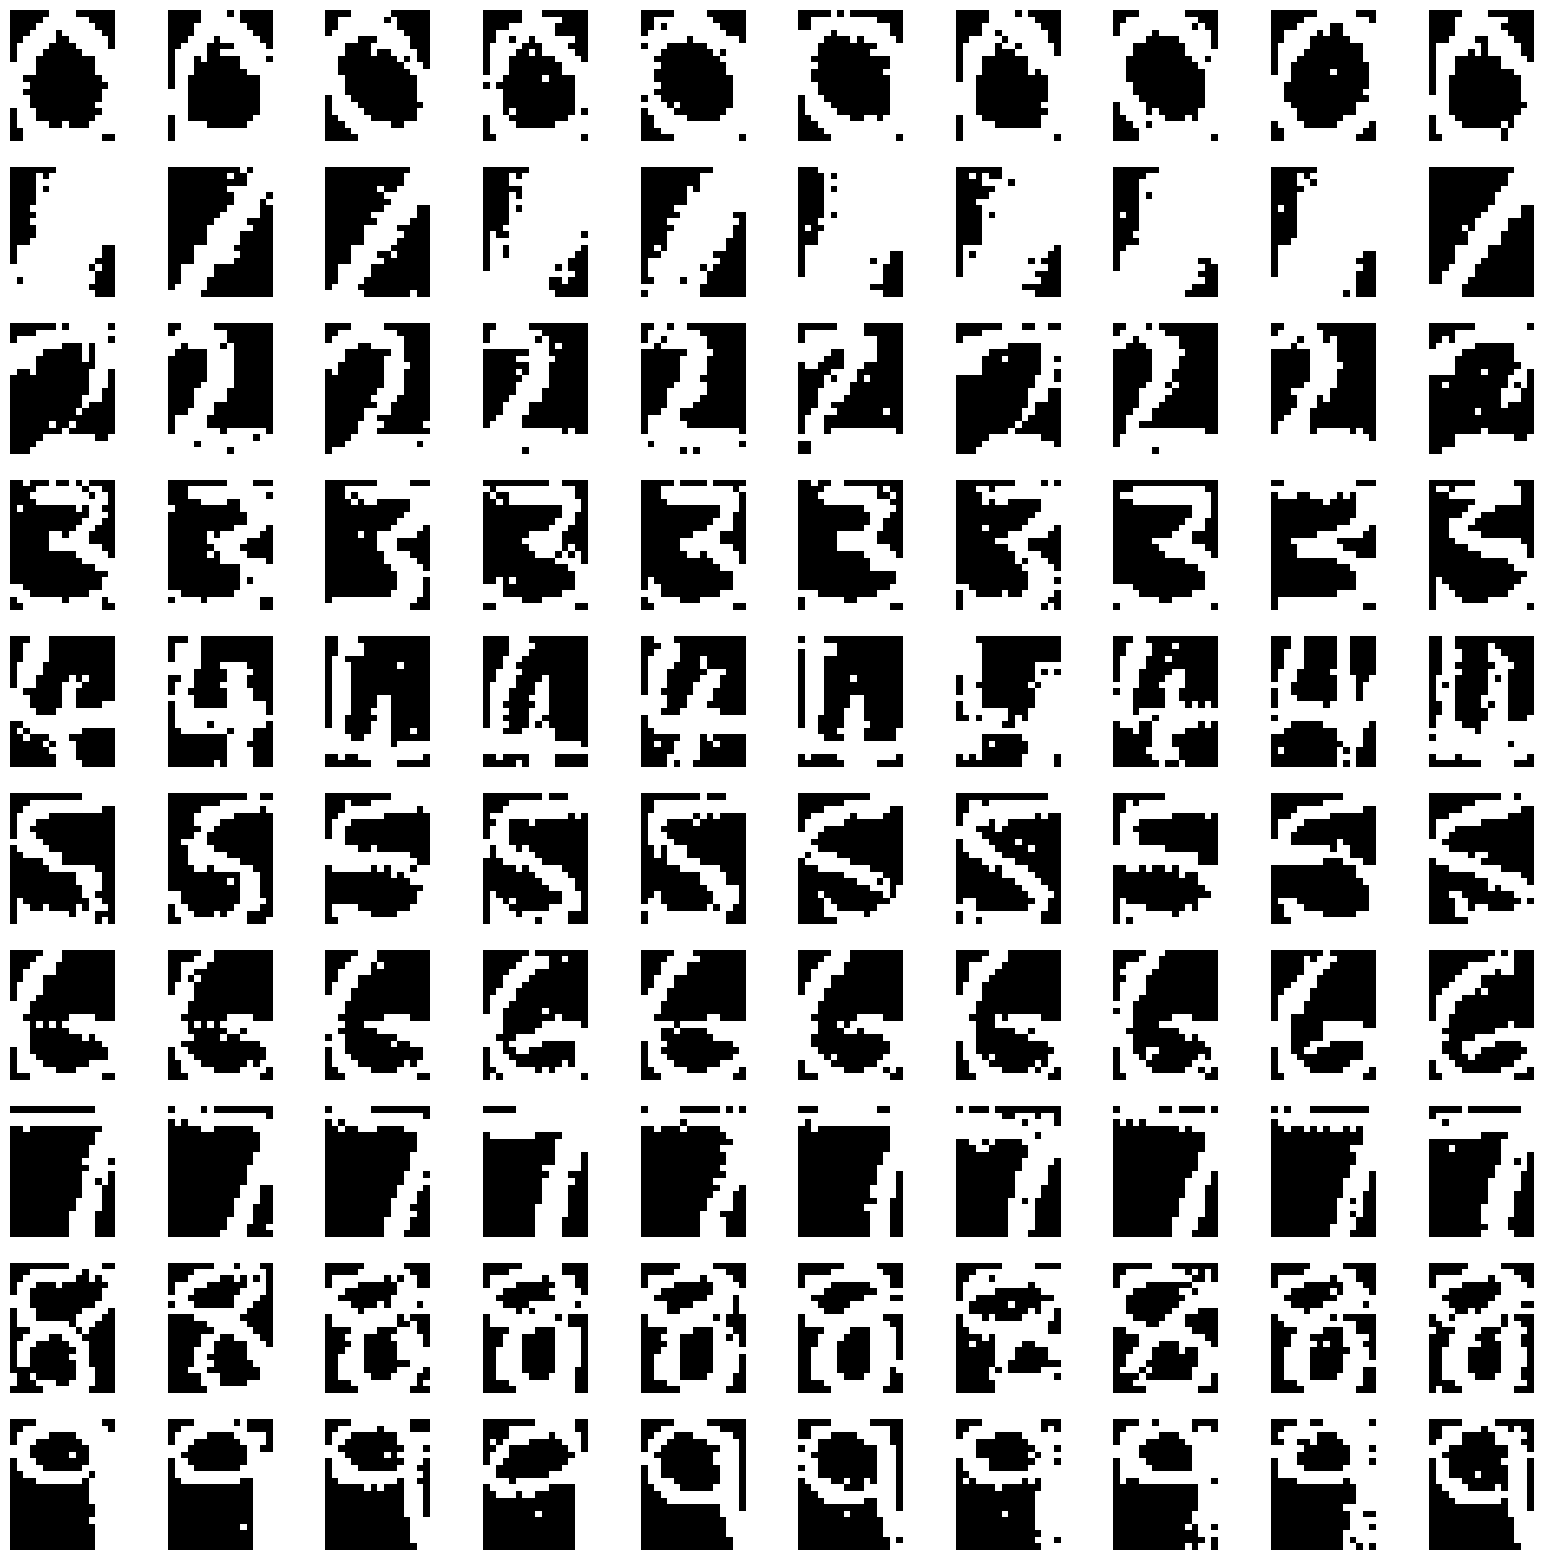

In [167]:
display_binary_vectors(binary_list, cols=10,  rows=10)

## Training while changing the number of layers of the DBN

In [220]:
first = [320]
last = [500]
middle = [500]

binary_temp = []

for i in range(1, 6):
    X = lire_alpha_digit([1,2,3,4,5], data)
    middle_net = i * middle
    network_size = first + middle_net + last

    dbn = DBN(network_size)
    hist = dbn.train_dbn(X, epochs=1000, lr=0.01, batchsize=32, verbose=1000)

    for j in range(1, 11):
        binary_temp.append(dbn.generer_image_DBN(1, 100 * j))

binary_list = []
for i in binary_temp:
    for vector in i:
        binary_list.append(vector)

Training RBM 1
epoch 1000, rec loss: 0.040722656249999996
Training RBM 2
epoch 1000, rec loss: 0.05701115754760299
Training RBM 1
epoch 1000, rec loss: 0.044531249999999994
Training RBM 2
epoch 1000, rec loss: 0.05750930667681219
Training RBM 3
epoch 1000, rec loss: 0.05922636665800588
Training RBM 1
epoch 1000, rec loss: 0.04153645833333334
Training RBM 2
epoch 1000, rec loss: 0.05725414095895209
Training RBM 3
epoch 1000, rec loss: 0.05784153628883177
Training RBM 4
epoch 1000, rec loss: 0.05496809880900974
Training RBM 1
epoch 1000, rec loss: 0.04391276041666667
Training RBM 2
epoch 1000, rec loss: 0.0558339290830386
Training RBM 3
epoch 1000, rec loss: 0.05955463518102839
Training RBM 4
epoch 1000, rec loss: 0.05641438262865619
Training RBM 5
epoch 1000, rec loss: 0.061222397970450225
Training RBM 1
epoch 1000, rec loss: 0.044596354166666664
Training RBM 2
epoch 1000, rec loss: 0.05346646443182495
Training RBM 3
epoch 1000, rec loss: 0.05840470913882895
Training RBM 4
epoch 1000, r

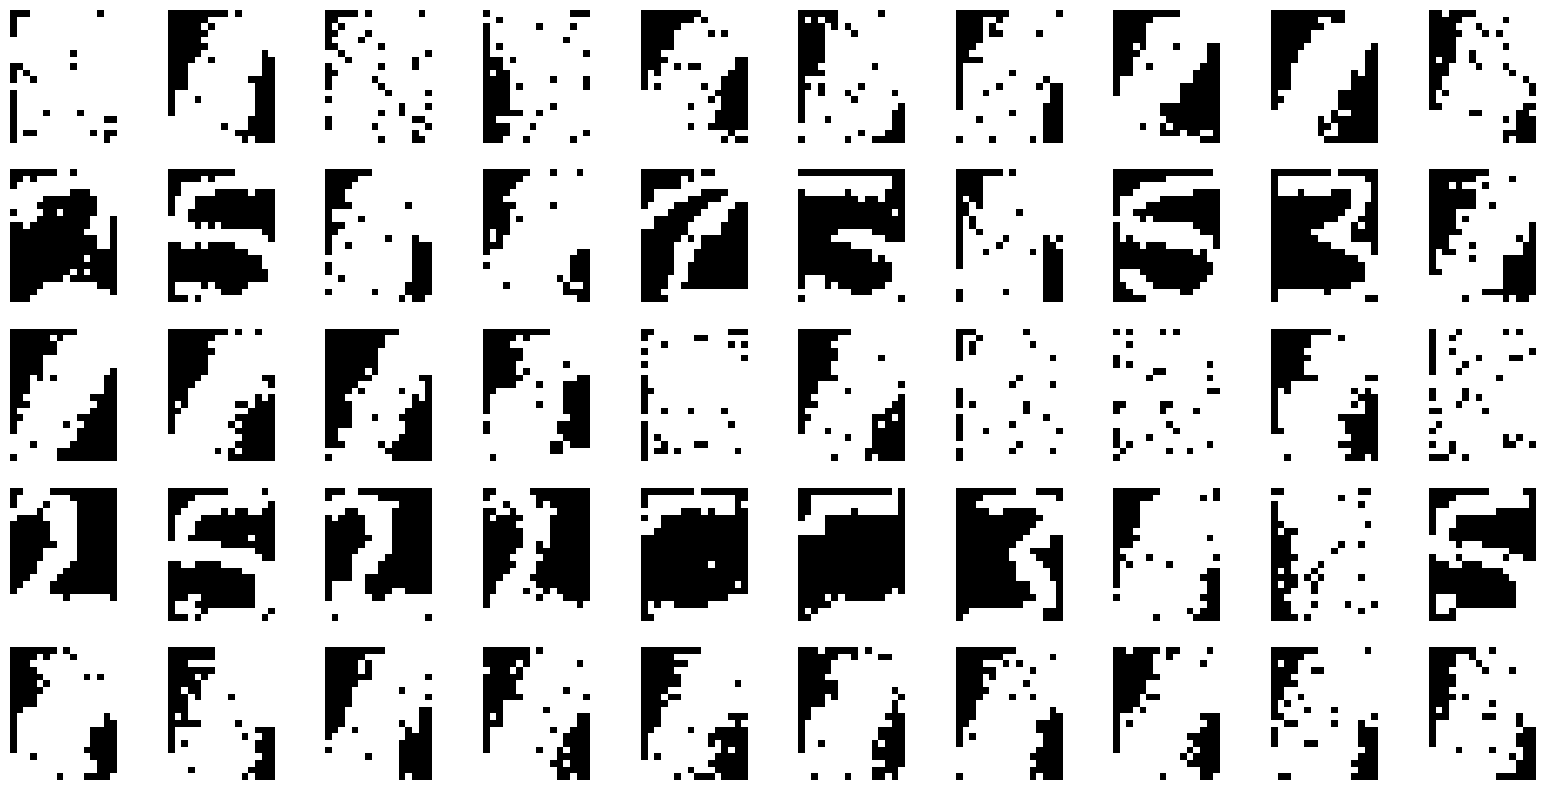

In [221]:
display_binary_vectors(binary_list, cols=10,  rows=5)

## Effect of the number of labels in Training

epoch 500, rec loss: 0.05673828125
epoch 1000, rec loss: 0.0271484375
epoch 500, rec loss: 0.108740234375
epoch 1000, rec loss: 0.0681640625
epoch 500, rec loss: 0.128466796875
epoch 1000, rec loss: 0.082177734375
epoch 500, rec loss: 0.105029296875
epoch 1000, rec loss: 0.06672363281249999
epoch 500, rec loss: 0.09583333333333333
epoch 1000, rec loss: 0.06092122395833333
epoch 500, rec loss: 0.10366210937499999
epoch 1000, rec loss: 0.06691080729166667
epoch 500, rec loss: 0.08887939453125
epoch 1000, rec loss: 0.05584716796875
epoch 500, rec loss: 0.0964599609375
epoch 1000, rec loss: 0.0591552734375
epoch 500, rec loss: 0.089970703125
epoch 1000, rec loss: 0.060888671875
epoch 500, rec loss: 0.08207194010416667
epoch 1000, rec loss: 0.05381673177083333


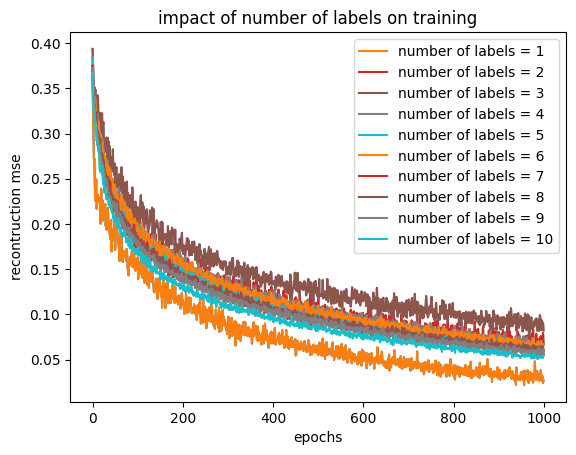

In [222]:
binary_temp = []
for j in range(1, 11):
    X = lire_alpha_digit(list(range(j)),data)
    rbm = RBM(X.shape[1], 800)
    # print(j, X.shape)
    if j ==1:
        hist = rbm.train(X,lr=1e-2,epochs=1000, batchsize=32, verbose = 500)
    else:
        hist = rbm.train(X,lr=1e-2,epochs=1000, batchsize=64, verbose = 500)

    plt.plot(hist, label=f"number of labels = {j}")

    for i in range(1,11):
        # print(i)
        binary_temp.append(rbm.generer_image_RBM(1, 100 * i))

plt.title("impact of number of labels on training")
plt.xlabel("epochs")
plt.ylabel("recontruction mse")
plt.legend()

binary_list = []
for i in binary_temp:
    for vector in i:
        binary_list.append(vector)


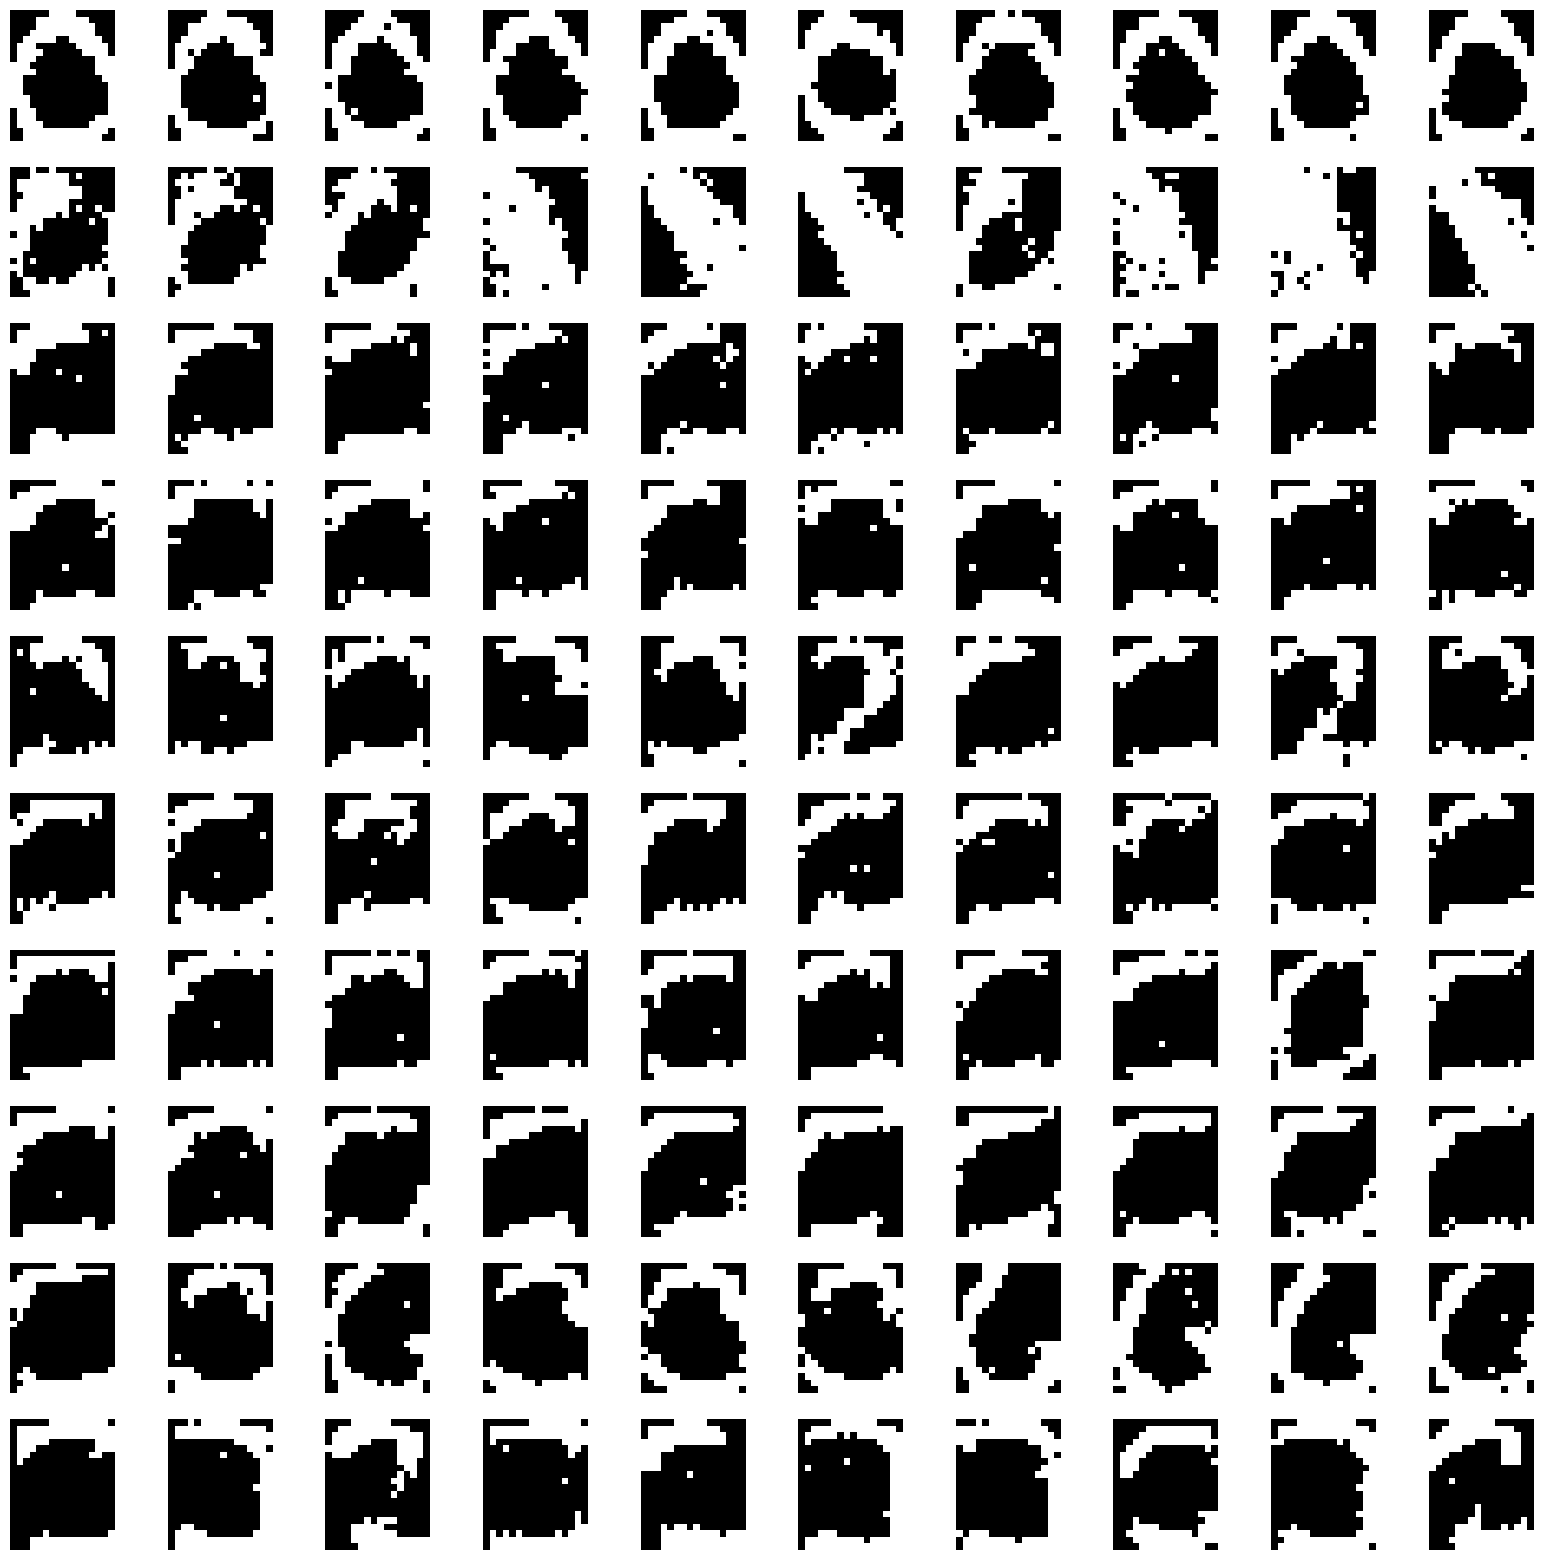

In [223]:
binary_list = []
for i in binary_temp:
    for vector in i:
        binary_list.append(vector)

display_binary_vectors(binary_list, cols=10, rows=10)

## Test on MNIST for DNN and comparison between pretrained and not

### Influence of the number of hidden layers

Epoch 0 : loss = 2.330601668409423, accuracy = 0.1075
Epoch 0 : loss = 2.328446940733902, accuracy = 0.0815
Epoch 0 : loss = 2.3458145209370156, accuracy = 0.0905
Pretraining layer 0
epoch 100, rec loss: 0.0669842155612245
Pretraining layer 1
epoch 100, rec loss: 0.1406266528023972
Epoch 0 : loss = 2.214509169377469, accuracy = 0.21
Pretraining layer 0
epoch 100, rec loss: 0.06637217639071757
Pretraining layer 1
epoch 100, rec loss: 0.1381749020095376
Pretraining layer 2
epoch 100, rec loss: 0.11712837298516163
Epoch 0 : loss = 2.2453039328221287, accuracy = 0.182
Pretraining layer 0
epoch 100, rec loss: 0.0665239003867676
Pretraining layer 1
epoch 100, rec loss: 0.13906720646177936
Pretraining layer 2
epoch 100, rec loss: 0.11481688181562656
Pretraining layer 3
epoch 100, rec loss: 0.12587287670204172
Pretraining layer 4
epoch 100, rec loss: 0.09989049936467033
Epoch 0 : loss = 2.232211132121555, accuracy = 0.2045


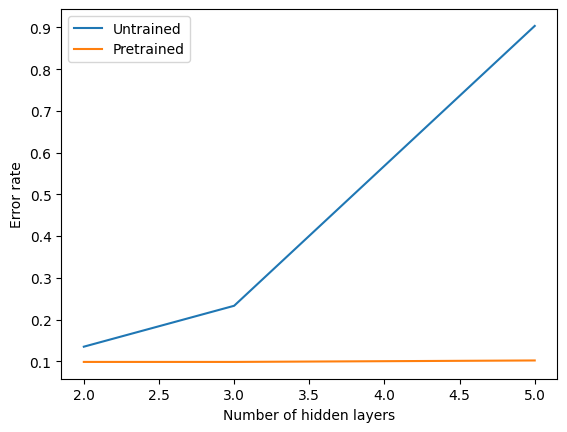

In [233]:
data_size = 2000
images_train, labels_train, images_test, labels_test = lire_MNIST(shuffle=True, data_size=data_size)

# Binarize data
images_train = (images_train > 127) * 1
images_test = (images_test > 127) * 1

# Vectorize labels
labels_train = np.eye(10)[labels_train]

first = [784]
middle = [200]
last = [10]

error_rate_untrained = []
for i in [2,3,5]:
    network_size = first + i * middle + last
    dnn = DNN(network_size)
    loss, accuracy = dnn.retropropagation(images_train, labels_train, epochs=100, lr=0.01, batchsize=32, verbose=100, plot=False)
    error_rate = dnn.test_DNN(images_test, labels_test)
    error_rate_untrained.append(error_rate)
print("\n")
error_rate_pretrained = []
for i in [2,3,5]:
    network_size = first + i * middle + last
    dnn = DNN(network_size)
    dnn.pretrain(images_train, epochs=100, lr=0.01, batchsize=32, verbose=100)
    loss, accuracy = dnn.retropropagation(images_train, labels_train, epochs=100, lr=0.01, batchsize=32, verbose=100, plot=False)
    error_rate = dnn.test_DNN(images_test, labels_test)
    error_rate_pretrained.append(error_rate)

plt.plot([2,3,5], error_rate_untrained, label="Untrained")
plt.plot([2,3,5], error_rate_pretrained, label="Pretrained")
plt.xlabel("Number of hidden layers")
plt.ylabel("Error rate")
plt.legend()
plt.show()

### Influence of the number of hidden units

In [234]:
data_size = 2000
images_train, labels_train, images_test, labels_test = lire_MNIST(shuffle=True, data_size=data_size)

# Binarize data
images_train = (images_train > 127) * 1
images_test = (images_test > 127) * 1

# Vectorize labels
labels_train = np.eye(10)[labels_train]

first = [784]
last = [10]

error_rate_untrained = []
for i in [100, 200, 300, 700]:
    network_size = first + 2*[i] + last
    dnn = DNN(network_size)
    loss, accuracy = dnn.retropropagation(images_train, labels_train, epochs=100, lr=0.01, batchsize=32, verbose=99, plot=False)
    error_rate = dnn.test_DNN(images_test, labels_test)
    print(f"Error rate for {i} hidden units: {error_rate}")
    error_rate_untrained.append(error_rate)
print("\n")
error_rate_pretrained = []
for i in [100, 200, 300, 700]:
    network_size = first + 2*[i] + last
    dnn = DNN(network_size)
    dnn.pretrain(images_train, epochs=100, lr=0.01, batchsize=32, verbose=99)
    loss, accuracy = dnn.retropropagation(images_train, labels_train, epochs=100, lr=0.01, batchsize=32, verbose=99, plot=False)
    error_rate = dnn.test_DNN(images_test, labels_test)
    print(f"Error rate for {i} hidden units with pretraining: {error_rate}")
    error_rate_pretrained.append(error_rate)

Epoch 0 : loss = 2.3606162259061856, accuracy = 0.0995
Epoch 99 : loss = 0.8450570717838468, accuracy = 0.7875
Error rate for 100 hidden units: 0.2285
Epoch 0 : loss = 2.356221104051307, accuracy = 0.079
Epoch 99 : loss = 0.5261117689030672, accuracy = 0.876
Error rate for 200 hidden units: 0.149
Epoch 0 : loss = 2.3807180002716315, accuracy = 0.103
Epoch 99 : loss = 0.4215321081148821, accuracy = 0.9
Error rate for 300 hidden units: 0.1295
Epoch 0 : loss = 2.300920343195094, accuracy = 0.1735
Epoch 99 : loss = 0.2990866697724421, accuracy = 0.919
Error rate for 700 hidden units: 0.1145
Pretraining layer 0
epoch 99, rec loss: 0.08180430690421328
Pretraining layer 1
epoch 99, rec loss: 0.16049347872910263
Epoch 0 : loss = 2.3343369546089425, accuracy = 0.167
Epoch 99 : loss = 0.40455644990061074, accuracy = 0.894
Error rate for 100 hidden units with pretraining: 0.115
Pretraining layer 0
epoch 99, rec loss: 0.06586492964121134
Pretraining layer 1
epoch 99, rec loss: 0.14017694642313736


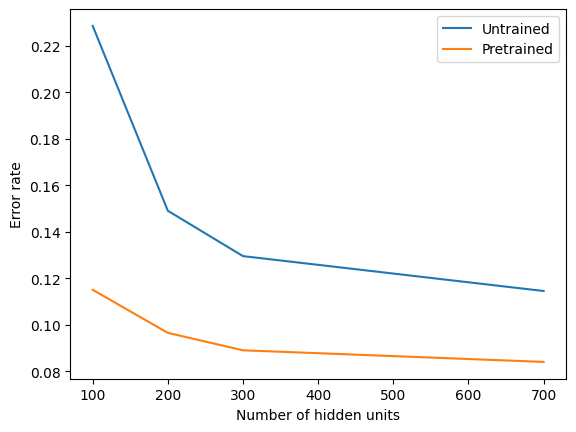

In [235]:
plt.plot([100, 200, 300, 700], error_rate_untrained, label="Untrained")
plt.plot([100, 200, 300, 700], error_rate_pretrained, label="Pretrained")
plt.xlabel("Number of hidden units")
plt.ylabel("Error rate")
plt.legend()
plt.show()

### Number of data used for training

Epoch 0 : loss = 2.3737977389585567, accuracy = 0.113
Epoch 99 : loss = 0.7031223963585549, accuracy = 0.86
Pretraining layer 0
epoch 99, rec loss: 0.0665656887755102
Pretraining layer 1
epoch 99, rec loss: 0.15426830839248726
Epoch 0 : loss = 2.1886904620606655, accuracy = 0.201
Epoch 99 : loss = 0.4018701250177014, accuracy = 0.893
Epoch 0 : loss = 2.2907143983351324, accuracy = 0.16433333333333333
Epoch 99 : loss = 0.3759254272204383, accuracy = 0.9063333333333333
Pretraining layer 0
epoch 99, rec loss: 0.053765155255650655
Pretraining layer 1
epoch 99, rec loss: 0.12973070248777965
Epoch 0 : loss = 2.0908124907368997, accuracy = 0.28733333333333333
Epoch 99 : loss = 0.25338664300500047, accuracy = 0.9336666666666666
Epoch 0 : loss = 2.2612422809173696, accuracy = 0.18885714285714286
Epoch 99 : loss = 0.269293413816432, accuracy = 0.923
Pretraining layer 0
epoch 99, rec loss: 0.044685825161486614
Pretraining layer 1
epoch 99, rec loss: 0.11715294013491302
Epoch 0 : loss = 1.68823166

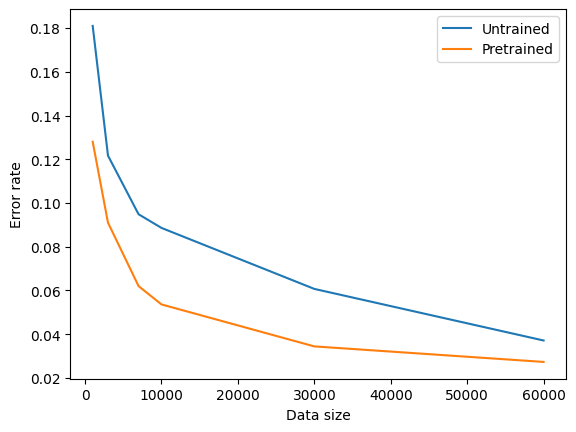

In [237]:
error_rate_untrained = []
error_rate_pretrained = []

for i in [1000, 3000, 7000, 10000, 30000, 60000]:
    data_size = i
    images_train, labels_train, images_test, labels_test = lire_MNIST(shuffle=True, data_size=data_size)

    # Binarize data
    images_train = (images_train > 127) * 1
    images_test = (images_test > 127) * 1

    # Vectorize labels
    labels_train = np.eye(10)[labels_train]

    network_size = [784, 300, 300, 10]

    dnn_untrained = DNN(network_size)
    loss, accuracy = dnn_untrained.retropropagation(images_train, labels_train, epochs=100, lr=0.01, batchsize=32, verbose=99, plot=False)
    error_rate_1 = dnn_untrained.test_DNN(images_test, labels_test)
    error_rate_untrained.append(error_rate_1)

    dnn_pretrained = DNN(network_size)
    dnn_pretrained.pretrain(images_train, epochs=100, lr=0.01, batchsize=32, verbose=99)
    loss, accuracy = dnn_pretrained.retropropagation(images_train, labels_train, epochs=100, lr=0.01, batchsize=32, verbose=99, plot=False)
    error_rate_2 = dnn_pretrained.test_DNN(images_test, labels_test)
    error_rate_pretrained.append(error_rate_2)

plt.plot([1000, 3000, 7000, 10000, 30000, 60000], error_rate_untrained, label="Untrained")
plt.plot([1000, 3000, 7000, 10000, 30000, 60000], error_rate_pretrained, label="Pretrained")
plt.xlabel("Data size")
plt.ylabel("Error rate")
plt.legend()

plt.show()

# Test on MNIST Data RBM and VAE

## Training RBM on MNIST

epoch 5, rec loss: 0.08665905612244897
epoch 10, rec loss: 0.07386772959183673
epoch 15, rec loss: 0.06711632653061224
epoch 20, rec loss: 0.06360191326530612
epoch 25, rec loss: 0.05930931122448979
epoch 30, rec loss: 0.05693826530612246


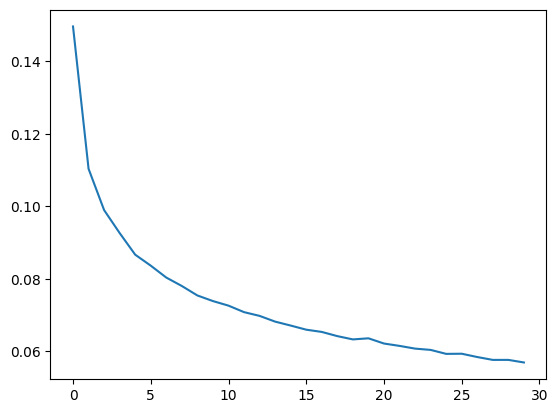

In [239]:
data_size = 10000
images_train, _, _, _ = lire_MNIST(shuffle=True, data_size=data_size)

# Binarize data
images_train = (images_train > 127) * 1

rbm = RBM(p=784, q=1000)

rbm.train(images_train,lr=5e-3, epochs=30, batchsize=100, verbose=5)

binary_temp = []
for j in range(1,11):
    binary_temp.append(rbm.generer_image_RBM(10, 100 * j))

binary_list = []
for i in binary_temp:
    for vector in i:
        binary_list.append(vector)

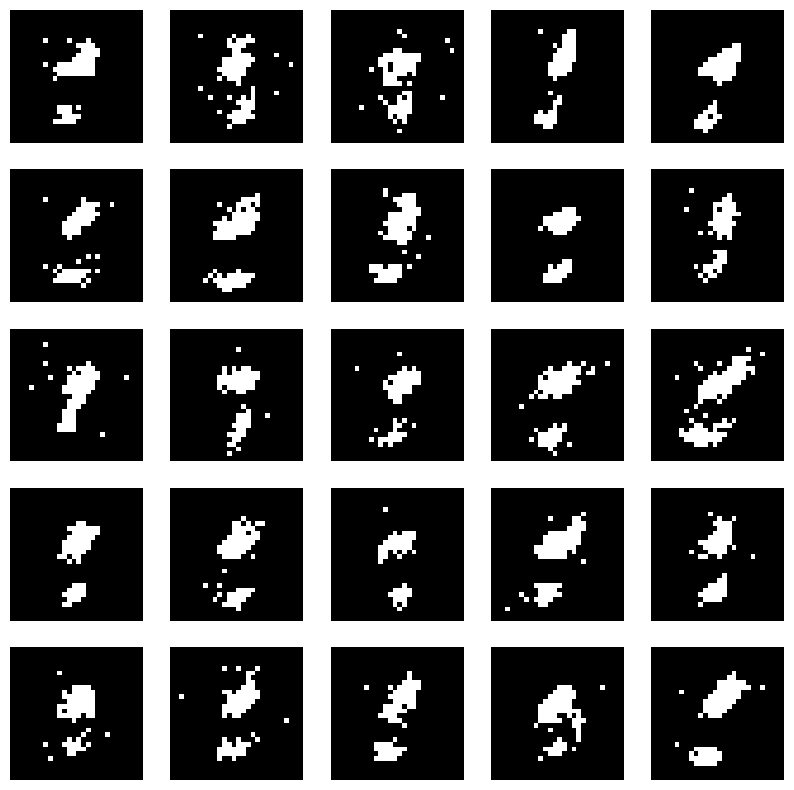

In [240]:
gen_samples = rbm.generer_image_RBM(25, 700 )
display_binary_vectors(gen_samples, cols=5, rows=5, shape=(28,28))

# Comparing with Neural networks - Variational Auto-encoders

required installation:

In [227]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("will use", device, "device.")

will use cuda device.


## Define VAE model
Below is defined the VAE model, it is very much like the RBM, we have an encoder that outputs a distribution for the latent space,
and a Decoder that computes a distribution for the input space. The difference lies in the copuational structure (that gives more flexibility to the VAE than the RBM has) and the fact that the parameters used for forward and backward are different (whereas we use the same weight matrix $W$ in the RBM). 

In [241]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 784)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x)
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


# model instantiation
model = VAE()

print(f"Created VAE model with {count_parameters(model)} parameters")


Created VAE model with 204832 parameters


## VAE Training
Here we train the VAE on the same dataset as we trained our RBM model

Epoch: 0 Average loss: 387.5525
Epoch: 50 Average loss: 120.3617
Epoch: 100 Average loss: 110.1372
Epoch: 150 Average loss: 104.9163
Epoch: 200 Average loss: 101.7113
Epoch: 250 Average loss: 99.5920
Epoch: 300 Average loss: 97.9797
Epoch: 350 Average loss: 96.7679
Epoch: 400 Average loss: 95.7046
Epoch: 450 Average loss: 94.9698
Epoch: 500 Average loss: 94.3267
Epoch: 550 Average loss: 93.7439


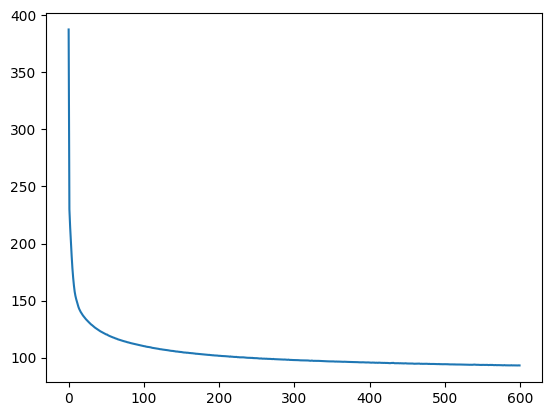

In [242]:
data_size = 10000
images_train, _, _, _ = lire_MNIST(shuffle=True, data_size=data_size)

# Binarize data
images_train = (images_train > 127) * 1

#training hyperparameters
epochs = 600
lr = 1e-3
batch_size = 300
verbose = 50

#training data : **Same as previously used for RBM for fair comparison**
train_data_tensor = torch.from_numpy(images_train).float()
trainloader = DataLoader(train_data_tensor, shuffle=True, batch_size=batch_size)


optimizer = torch.optim.Adam(model.parameters(), lr = lr)

def loss_function(y, x, mu, std): 
    # binary cross entropy for logits
    ERR = F.binary_cross_entropy(y, x, reduction='sum')
    
    # KL divergence for the latent space distribution 
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

model.to(device)
model.train()

losses = []
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        
    mean_loss = - train_loss / len(trainloader.dataset)
    losses.append(mean_loss)
    if epoch%verbose ==0:
        print('Epoch: {} Average loss: {:.4f}'.format(epoch, mean_loss))
  

plt.plot(losses)
plt.show()


## VAE Evaluation

### reconstruction evaluation

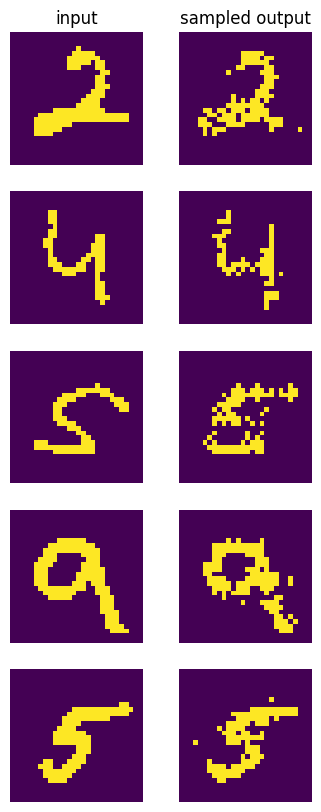

In [243]:
model.eval()
model.cpu()
n_test = 5
f, axarr = plt.subplots(n_test,2,figsize=(4,2*n_test))
for i in range(n_test):
  a = next(iter(trainloader))
  recon, mu, std = model(a[0])
  sampled = (torch.rand(recon.shape) < recon) * 1.0
  b = sampled.reshape((28,28))
  c = a[0].reshape((28,28))

  #plot input and result after encoding and decoding
  axarr[i,0].imshow(c.detach().cpu().numpy())
  axarr[i,1].imshow(b.detach().cpu().numpy())
  axarr[i,0].axis("off")
  axarr[i,1].axis("off")

  axarr[0,0].set_title("input")
  axarr[0,1].set_title("sampled output")


### Random Sampling with VAE
we can now generate new images with our VAE. Here we get far better results without having to iterate with Gibbs sampling ! Note that we have a great deal more parameters than the RBM, which undeniably counts

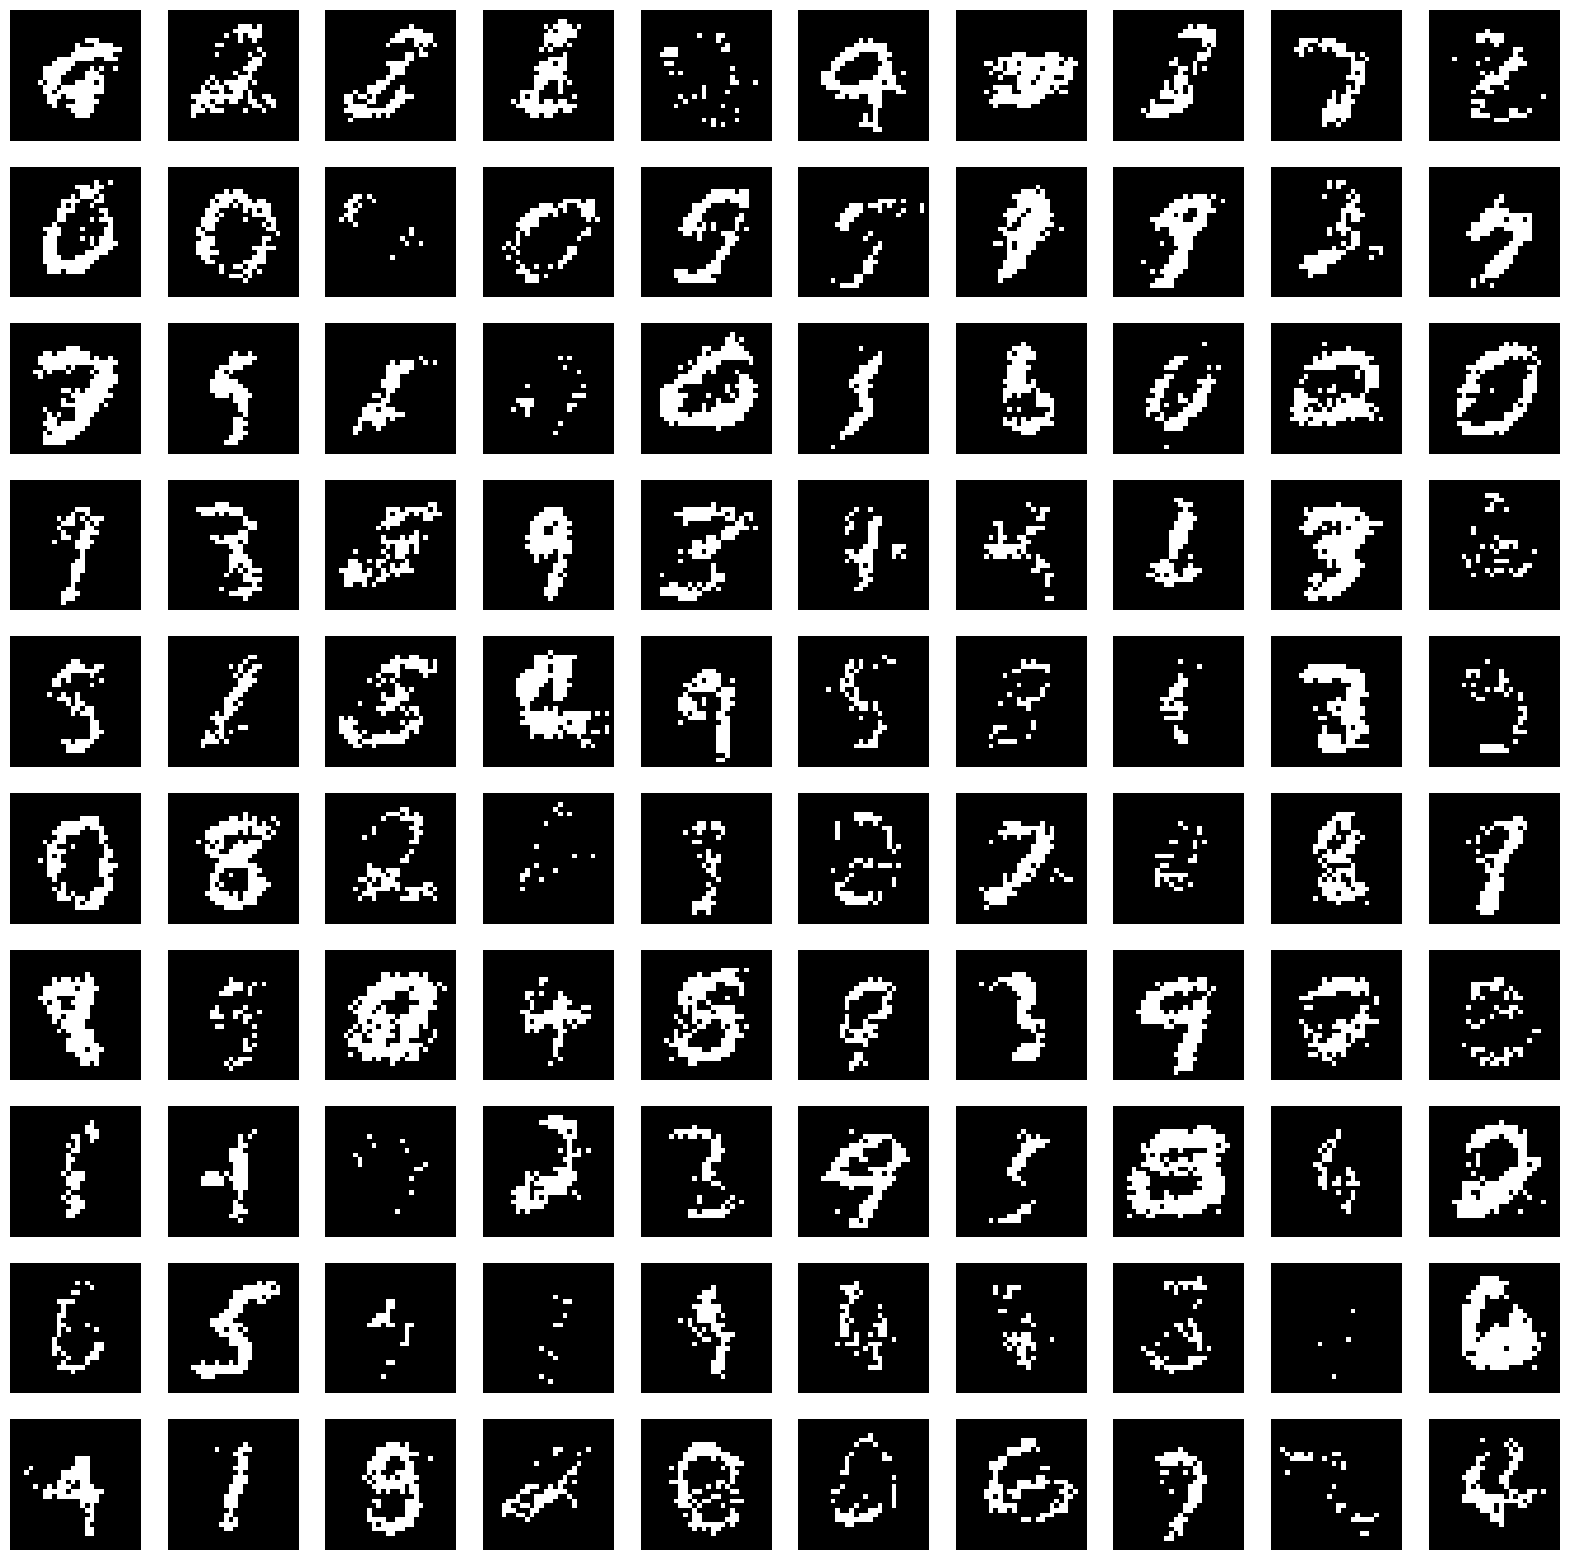

In [244]:
test_list = []

for i in range(100):
  x = np.random.normal(0,1, 8)
  x= x.astype(np.float32)
  x=torch.from_numpy(x)
  recon = model.decoder(x)
  sampled = (torch.rand(recon.shape) < recon) * 1.0
  b = sampled.reshape((28,28)).detach().cpu().numpy()
  b = np.where(b > 0.1, 1, 0)
  test_list.append(b)

display_binary_vectors(test_list, cols=10, rows=10, shape=(28,28))